In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
from scipy.special import gamma
import time
try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
###

from scipy.stats import pearsonr, zscore
from MFDFA import fgn
# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()
from tqdm import tqdm
import os
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

import stylised_facts_data_utilities.createLOB as createLOB
import stylised_facts_data_utilities.gpyNARX as gpyNARX
import stylised_facts_data_utilities.longtaildistr as longtail
%matplotlib inline
import os
os.getcwd()

'/home/ak/Documents/Research/PaperCode/stylised_facts'

In [2]:
# import numerical libraries

from scipy import stats
# import tableone
try:
    from tableone import TableOne
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne

### Assumptions and Investigations

1/ By moving to the tick domain, the need to force each trade into a time slot is removed as one does
not need to force the trades into predetermined sampling points as in calendar time. Additionally, when using calendar time sampling

2/ can we recover normality in each of the assets and periods?

3/duration between trades is
also added to the subordination framework to account for
the speed with which market participants act in physical
time.

4/we bring qualitative empirical evidence that the impact of a single
trade depends on the intertrade time lags. We find that when the trading rate be- comes faster, the return variance per trade strongly increases and that this behavior persists at coarser time scales. 

5/So we answer the following question: is the realized variance created by 10 trades arriving over 10 seconds similar to the realized variance created by those very same trades had they arrived during 10 minutes? Any model that uses a transaction time clock implies that the two situations are similar. Our empirical findings show that they are not, and that trades arriving in a shorter duration have higher variance, thus showing the importance of the physical inter-trade time duration. 

In [3]:
ActivityCLockData= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData= '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)
ActivityClockDataList = os.listdir(ActivityCLockData)

symbols =['FB1','JB1','FV1','G_1']

In [4]:
symbolIdx=0
pklList = list(np.sort([s for s in OHLCDataList if (str(symbols[symbolIdx])) in s and ('ohlcFile') in s]))
combinedDF = pd.DataFrame()
for pklIdx, _ in enumerate(pklList):

    pklOHLCFile = "".join((OHLCData,pklList[pklIdx]))
    combinedDF = combinedDF.append(pickle.load(open(pklOHLCFile , "rb")))

In [5]:
# fileIdx=0
# FV1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('FV1') in s])
# combinedSymbolClockDF = pd.DataFrame()
# for pklIdx, _ in enumerate(pklList):

#     pklClockFile = "".join((ActivityCLockData,FV1ClocksData[pklIdx]))
#     combinedSymbolClockDF = combinedSymbolClockDF.append(pickle.load(open(pklClockFile , "rb")))

In [6]:
FV1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('FV1') in s])
pklidx=1
tickBarDictCondensed = dict()
for pklidx in range(0,39):
    pklClockFile = "".join((ActivityCLockData,FV1ClocksData[pklidx]))
    tickBarDF =pickle.load(open(pklClockFile , "rb"))['TickBarDf'] #tickbar
    tickBarDictCondensed[FV1ClocksData[pklidx].split('_')[3]]=tickBarDF [['BidSize', 'QuoteTime','BestBid',
       'TradeTime', 'AskSize','BestAsk', 'TradeVolume', 'TradedTime', 'type',
       'TradePrice', 'TimeStamp', 'milliSeconds','DollarVolume', 'MicroPrice', 'TradeSize', 'DollarVolumeTraded']]


In [7]:
keys = list(tickBarDictCondensed.keys())

In [8]:
dfMicroPrice = pd.DataFrame()
testFile =pd.concat(list(tickBarDictCondensed.values() ), axis =0, keys = list(tickBarDictCondensed.keys()))


In [20]:
def microPriceReturns(key):
    return np.array(tickBarDictCondensed[str(key)].MicroPrice.pct_change().fillna(0))


In [27]:
# key= keys[1]
# for key in keys:
#     print(len(microPriceReturns(key)))

#write a piece of code that essentially looks at returns across all the clocks and then assesses normality of returns. do we recover normality using different clocks?

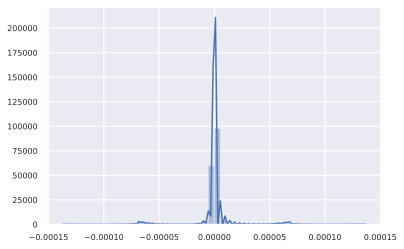

In [32]:
key= keys[2]
mpr=microPriceReturns(key)
sns.distplot(microPriceReturns(key));


In [33]:
longtail.fit_distributions(mpr)

{'norm': (2.651934882680355e-09, 1.9787361128831204e-05),
 'laplace': (1.291722230202072e-13, 6.645550713426169e-06),
 'cauchy': (1.0083402571581248e-08, 7.585842647857153e-07)}

In [13]:
import longtail
import numpy as np

Estimating distributions parameters...
norm (2.651934882680355e-09, 1.9787361128831204e-05)
laplace (1.291722230202072e-13, 6.645550713426169e-06)
cauchy (1.0083402571581248e-08, 7.585842647857153e-07)


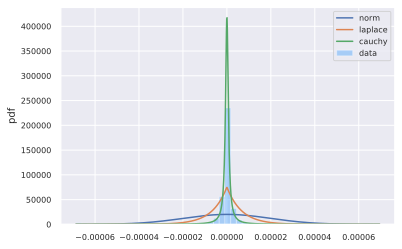

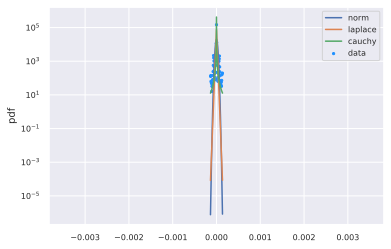

dict

In [34]:
type(longtail.plot(mpr))

In [35]:
def sample_hsic(n, angle, sigma=0.2, offset=1):
    n4 = int(n/4)
    N = np.random.randn(n4, 2)*sigma
    S = np.random.randn(n4, 2)*sigma
    E = np.random.randn(n4, 2)*sigma
    W = np.random.randn(n4, 2)*sigma
    
    N[:,1] += offset
    S[:,1] -= offset
    W[:,0] -= offset
    E[:,0] += offset
    
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    A = R.dot(np.vstack((N,S,W,E)).T).T
    
    return A[:,0], A[:,1]


In [16]:
# N=200
# np.random.seed(0)
# X,Y = sample_hsic(n=N, angle=np.pi/12)

TypeError: 'numpy.ndarray' object is not callable

In [36]:
X =microPriceReturns(key=keys[2])
Y =microPriceReturns(key=keys[1])

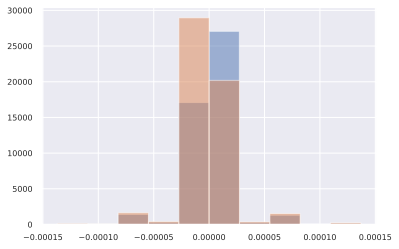

In [37]:
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5);

In [38]:
def simple_statistic(X,Y, squared=False):
    assert X.ndim == Y.ndim == 1
    
    # IMPLEMENT: compute mean difference of X and Y
    result = np.mean(X) - np.mean(Y)
    
    if squared:
        result *= result
    return result

In [39]:
my_statistic = simple_statistic(X,Y)
print("Mean differencce:", my_statistic)

Mean differencce: 1.693125098013031e-09


In [40]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim
    
    statistics = np.zeros(num_permutations)
    
    range_ = range(num_permutations)
    if prog_bar:
        range_ = tqdm(range_)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))
            
        # IMPLEMENT: permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics

num_permutations = 200
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

100%|██████████| 200/200 [00:00<00:00, 573.06it/s]


In [49]:
def plot_permutation_samples_sns(null_samples, statistic= None):
    sns.distplot(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5),ls='--', c='red')
    plt.axvline(x=np.percentile(null_samples, 2.5), ls='--', c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5),ls='--',  c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    

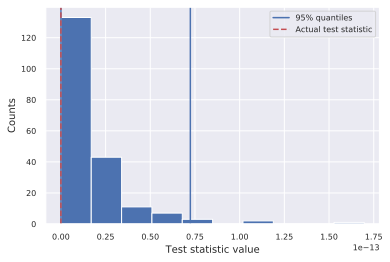

In [50]:
def plot_permutation_samples(null_samples, statistic=None):
    plt.hist(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic,ls='--',  c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    
plot_permutation_samples(statistics, my_statistic)

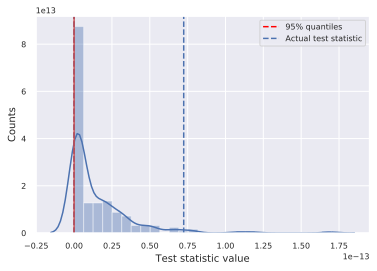

In [51]:
plot_permutation_samples_sns(statistics, my_statistic)

100%|██████████| 200/200 [00:00<00:00, 518.89it/s]


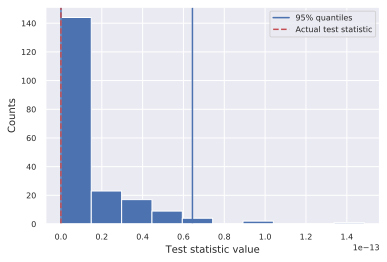

In [52]:
# IMPLEMENT: use squared test statistic
simple_statistic_squared = lambda X,Y: simple_statistic(X,Y,squared=True)

# visualise test
statistics = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y)
plot_permutation_samples(statistics, my_statistic)

100%|██████████| 200/200 [00:00<00:00, 16466.65it/s]


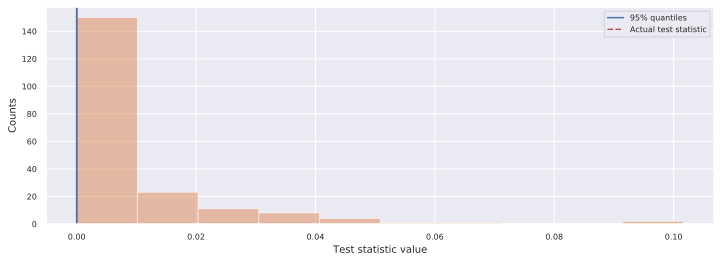

In [53]:
np.random.seed(0)
statistics_null = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y) # this is a single sample from the alternative
shift=0
statistics_alt = np.zeros(num_permutations)
for i in tqdm(range(num_permutations)):
    # IMPLEMENT: generate more data from the alternative
    X = np.random.randn(N)
    Y = np.random.randn(N)+shift
    
    statistics_alt[i] = simple_statistic_squared(X,Y)
    
plt.figure(figsize=(12,4))
plot_permutation_samples(statistics_null, my_statistic)    
plt.hist(statistics_alt, alpha=0.5);

In [54]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

In [55]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

100%|██████████| 200/200 [00:00<00:00, 501.87it/s]


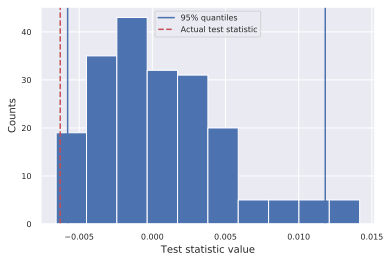

In [56]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

100%|██████████| 200/200 [00:00<00:00, 536.27it/s]


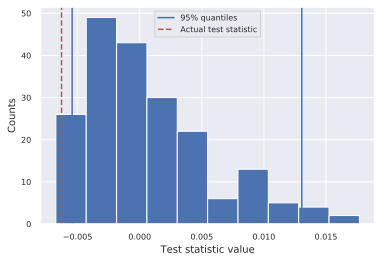

In [57]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

 /home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
 /home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


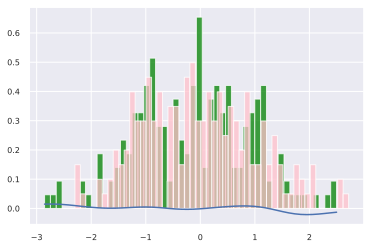

In [75]:
grid = np.linspace(np.min(X), np.max(X))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)

# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)
phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y

plt.plot(grid, witness)

plt.hist(X,  normed=True, facecolor='green', alpha=0.75, bins=50)
plt.hist(Y,  normed=True, facecolor='pink', alpha=0.75, bins=50);

As we can see, the witness function is positive where X as a higher density than Y, and negative vice versa.
It is zero where both densities match.
Intuitively, the RKHS norm of this function can only be zero if the densities match everywhere, and it grows as the densities differ on more and more points in their support.
Of course, this kind of visualization only works in few dimensions.